# Requirements

In [332]:
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer,DataCollatorWithPadding,TrainingArguments,AutoModelForSequenceClassification
import evaluate
import numpy as np
from transformers import Trainer
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [333]:
dataset = load_dataset("csv", data_files="./spotify-user-reviews.csv",split="train[:100]")
dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 100
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [334]:
df = dataset.to_pandas()
df["label"].unique()

array(['positive', 'negative'], dtype=object)

In [335]:
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
95,So in 2020i think i installed spotify and it w...,negative
96,"Great app, really easy to navigate. However, c...",positive
97,Love it! Can find most any song title or artis...,positive
98,Amazing i would say I'm not premium member but...,negative


In [336]:

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["label"])

In [337]:
dataset= dataset.remove_columns("label")
dataset = dataset.add_column("label", labels)
dataset = dataset.rename_column("review", "text")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})

In [338]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [339]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

In [340]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [341]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [342]:
tokenized_dataset = dataset.map(tokenize, batched=True)

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

Define the traning parameters using the `TrainingArguments` class.

In [343]:
training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # learning_rate=0.001,
    # report_to="none",
)

In [344]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Define the training using the `Trainer` class.

In [345]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [346]:
metric = evaluate.load("f1")

In [347]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [348]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [349]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [350]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Use the trained model to make predictions for the test set.

In [351]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.370486,0.900000


TrainOutput(global_step=5, training_loss=0.29311683177948, metrics={'train_runtime': 12.2148, 'train_samples_per_second': 6.549, 'train_steps_per_second': 0.409, 'total_flos': 2347156719936.0, 'train_loss': 0.29311683177948, 'epoch': 1.0})

In [352]:
trainer.evaluate()

{'eval_loss': 0.3704858422279358,
 'eval_f1': 0.9,
 'eval_runtime': 0.4513,
 'eval_samples_per_second': 44.317,
 'eval_steps_per_second': 4.432,
 'epoch': 1.0}

In [353]:
predictions = trainer.predict(tokenized_dataset["test"])

In [354]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [355]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



Text(0.5, 1.0, 'Confusion Matrix')

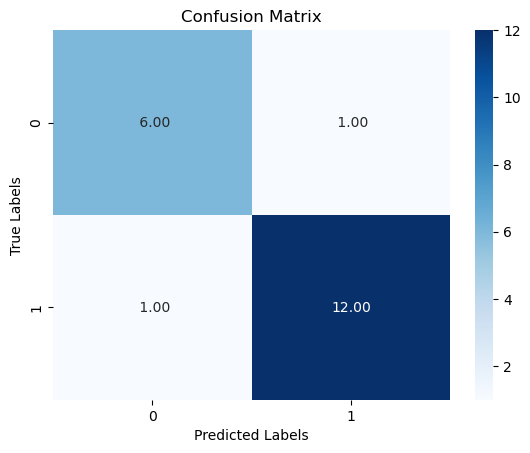

In [356]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [357]:
dataset = load_dataset("csv", data_files="./spotify-user-reviews.csv",split="train[:100]")
dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 100
})

In [358]:
encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["label"])
dataset= dataset.remove_columns("label")
dataset = dataset.add_column("label", labels)
dataset = dataset.rename_column("review", "text")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})

In [359]:
df = dataset.to_pandas()
df

,text,label
0,A huge collection of music,1
1,Downloaded music still can't be played offline...,0
2,This app is the best music app I have ever see...,1
3,"Works great just with the car's Bluetooth, but...",0
4,Best music app so far,1
...,...,...
95,So in 2020i think i installed spotify and it w...,0
96,"Great app, really easy to navigate. However, c...",1
97,Love it! Can find most any song title or artis...,1
98,Amazing i would say I'm not premium member but...,0


In [360]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(df['text'],  df['label'], test_size=0.2)

In [361]:
pipeline = make_pipeline_imb(
    TfidfVectorizer(),
    RandomUnderSampler(),
    LogisticRegression()
)

In [362]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler()),
                ('logisticregression', LogisticRegression())])

In [364]:
from imblearn.metrics import classification_report_imbalanced
y_pred = pipeline.predict(X_test)
print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.88      0.75      0.78      0.81      0.66         8
          1       0.90      0.75      0.88      0.82      0.81      0.65        12

avg / total       0.82      0.80      0.82      0.80      0.81      0.65        20

